In [1]:
import pandas as pd
pd.options.display.max_columns = 500

import numpy as np
from collections import defaultdict

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")

from pymystem3 import Mystem; mystem = Mystem()
from functools import lru_cache


from tqdm import tqdm
tqdm.pandas()

%matplotlib inline

### Ввод данных

In [2]:
data = pd.read_csv('../data/DATA_MANY_TOPICS.csv')
data = data[~((data.topic == 'forces') & (data.url.str.contains('https://www.gazeta.ru/')))]

In [3]:
data.drop('index', 1, inplace=True)
data.drop(data[data.topic == 'football'].sample(25000).index, inplace=True)
data.drop(data[data.topic == 'hockey'].sample(5000).index, inplace=True)
data.drop(data[data.topic == 'business'].sample(12000).index, inplace=True)
data.drop(data[data.topic == 'politics'].sample(5000).index, inplace=True)

In [4]:
data.sample(5)

,text,title,topic,url
32797,\n Завтра компания Boeing должна представить ...,\n Boeing в пятницу предста...,business,http://www.vedomosti.ru/business/articles/2013...
74363,Высший хозяйственный суд Украины признал закон...,Суд на Украине отклонил жалобу «Газпрома» на ш...,companies,https://lenta.ru/news/2016/07/13/gazprom_syd/
6431,\n \n \n В конце января 2015 г. собрание акци...,\n ПГК может заплатить мате...,business,http://www.vedomosti.ru/business/articles/2014...
95102,Президент России Владимир Путин внес в Госдуму...,Путин внес в Госдуму закон об исключении НКО и...,politics,https://lenta.ru/news/2015/02/04/putinnko/
73983,Одна из крупнейших американских авиакомпаний D...,Американская Delta прекратит полеты в Москву,companies,https://lenta.ru/news/2015/04/29/deltagameover/


In [5]:
print('Number of news:', len(data))

Number of news: 133529


In [6]:
print('Number of topics:', data.topic.nunique())

Number of topics: 32


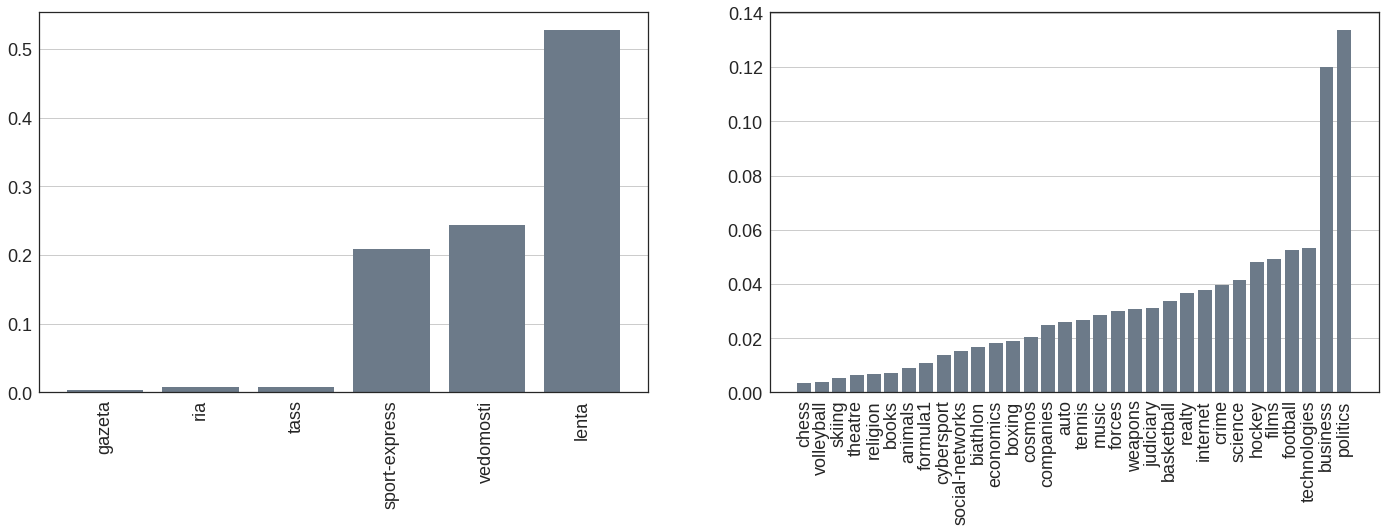

In [7]:
topics_freq = data.topic.value_counts(normalize=True, ascending=True)
media_freq = data.url.apply(lambda x: x.split('/')[2].replace('www.', '').replace('.ru', '')).value_counts(normalize=True, ascending=True)

font_size=18
fig, ax = plt.subplots(1, 2, figsize=(24, 7))
ax[0].bar(range(len(media_freq)), media_freq.values, color='#6C7A89')
ax[0].set_xticks(range(len(media_freq)))
ax[0].set_xticklabels(media_freq.index, rotation=90)
ax[0].tick_params(labelsize=font_size)
ax[0].yaxis.grid()

ax[1].bar(range(len(topics_freq)), topics_freq.values, color='#6C7A89')
ax[1].set_xticks(range(len(topics_freq)))
ax[1].set_xticklabels(topics_freq.index, rotation=90)
ax[1].tick_params(labelsize=font_size)
ax[1].yaxis.grid()
fig.savefig('../docs/images/media_topi_distr.pdf', bbox_inches='tight')

In [8]:
class Pipeline(object):
    def __init__(self, *args):
        self.transformations = args
    def __call__(self, x):
        res = x
        for f in self.transformations:
            res = f(res)
        return res

In [9]:
from nltk.corpus import stopwords
from stop_words import get_stop_words
en_sw = get_stop_words('en')
ru_sw = get_stop_words('ru')
STOP_WORDS = set(en_sw) | set(ru_sw)
STOP_WORDS = STOP_WORDS | set(stopwords.words('russian')) | set(stopwords.words('english'))
STOP_WORDS = STOP_WORDS | set(['лента', 'новость', 'риа', 'тасс',
                               'редакция', 'газета', 'корра', 'daily',
                               'village', 'интерфакс', 'reuters', 'уточняться'])

def remove_ria(text):
    prefix = text[:50]
    ria = 'РИА Новости'
    if ria in prefix:
        text = text[text.find(ria)+len(ria)+1:]
    return text

def remove_tass(text):
    prefix = text[:100]
    return text[max(0, prefix.find('/.')+1):]

def get_lower(text):
    return str(text).lower().strip()

def remove_punctuation(text):
    return ''.join([c if c.isalpha() or c in ['-',"'"] else ' ' for c in text])

@lru_cache(maxsize=None)
def get_word_normal_form(word):
    return ''.join(mystem.lemmatize(word)).strip().replace('ё', 'е').strip('-')

def lemmatize_words(text):
    res = []
    for word in text.split():
        norm_form = get_word_normal_form(word)
        if len(norm_form) > 2 and norm_form not in STOP_WORDS:
            res.append(norm_form)
    return ' '.join(res)

In [10]:
TEXT_PIPELINE = Pipeline(remove_tass, remove_ria, get_lower, remove_punctuation, lemmatize_words)

In [11]:
%%time
data.text = data.text.progress_apply(TEXT_PIPELINE)

100%|██████████| 133529/133529 [01:10<00:00, 1895.47it/s]

CPU times: user 50.4 s, sys: 2.79 s, total: 53.2 s
Wall time: 1min 10s


In [12]:
%%time
data.title = data.title.progress_apply(TEXT_PIPELINE)

100%|██████████| 133529/133529 [00:02<00:00, 46215.67it/s]

CPU times: user 2.55 s, sys: 44 ms, total: 2.6 s
Wall time: 2.9 s


In [13]:
vocabulary = defaultdict(int)
for news in data.itertuples():
    for word in news.text.split():
        vocabulary[word] += 1
print('Unique words in dataset:', len(vocabulary))

Unique words in dataset: 221299


In [14]:
n_min_occurance = 2
print('Number of words occured more than %d times: %d' % 
      (n_min_occurance, len(list(filter(lambda x: x[1] >= n_min_occurance, vocabulary.items())))))

Number of words occured more than 2 times: 130810


In [15]:
top_k = 20
print('Top %d most frequent words:' % top_k)
for i, (word, freq) in enumerate(sorted(vocabulary.items(), key=lambda x: -x[1])[:top_k]):
    print(i+1, word, freq)

Top 20 most frequent words:
1 россия 97940
2 сообщать 84250
3 компания 83968
4 свой 66420
5 российский 56077
6 становиться 51070
7 заявлять 48255
8 слово 45769
9 отмечать 41966
10 сша 40559
11 страна 39156
12 получать 39063
13 новый 38732
14 президент 37611
15 млрд 35300
16 ранее 32765
17 данный 31246
18 москва 30867
19 представитель 30209
20 млн 30089


# Получим baseline решение с помощью SVM

In [53]:
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, make_scorer, classification_report
from sklearn.svm import LinearSVC

from scipy.sparse import hstack

### Закодируем целевую переменную

In [17]:
le = LabelEncoder()
data.topic = le.fit_transform(data.topic)

### Разделим данные на train и validation

In [18]:
trainX = pd.concat([pd.DataFrame(data.title + ' ' + data.text, columns=['text']), data.url], axis=1)
trainY = data.topic

In [19]:
trainX.head()

,text,url
1,новак брюссельский договоренность снижать риск...,http://www.vedomosti.ru/business/news/2015/03/...
2,медведев поручать усовершенствовать защита бан...,http://www.vedomosti.ru/economics/news/2015/03...
3,россельхознадзор проинспектировать предприятие...,http://www.vedomosti.ru/economics/news/2015/03...
4,walt disney становиться самый прибыльный компа...,http://www.vedomosti.ru/technology/news/2015/0...
6,украина рассчитывать цена российский газ кварт...,http://www.vedomosti.ru/business/news/2015/03/...


In [20]:
X_train, X_test, y_train, y_test = train_test_split(trainX, trainY, test_size=0.3,
                                                    stratify=trainY, random_state=42)

### Вычислим tf-idf

In [21]:
%%time
tfidf_vectorizer = TfidfVectorizer(min_df=3, ngram_range=(1,2), lowercase=False).fit(trainX.text)
print(len(tfidf_vectorizer.vocabulary_))

1025015
CPU times: user 1min 3s, sys: 492 ms, total: 1min 3s
Wall time: 1min 3s


In [22]:
X_train_tf = tfidf_vectorizer.transform(X_train.text)
X_test_tf = tfidf_vectorizer.transform(X_test.text)

### Обучим SVM

In [95]:
# clf = LinearSVC(C=1, max_iter=10000, loss='hinge', random_state=42)
clf = SGDClassifier(loss='hinge', n_iter=70, random_state=42, n_jobs=8, alpha=1e-5)

In [96]:
%%time
clf.fit(X_train_tf, y_train)
svm_prediciton = clf.predict(X_test_tf)
print('F1 score:', f1_score(y_test, svm_prediciton, average='macro'))
print('Accuracy:', accuracy_score(y_test, svm_prediciton))

F1 score: 0.886029602088
Accuracy: 0.879228138496
CPU times: user 8min 10s, sys: 188 ms, total: 8min 10s
Wall time: 2min 3s


### Построим нормализованную матрицу потерь

In [99]:
def plot_confusion_matrix(true, pred, class_names, filename=None):
    cm = confusion_matrix(true, pred)
    cm_normalized = cm / cm.sum(axis=1)[:, np.newaxis]
    classes = [c for c in class_names]
    df_cm = pd.DataFrame(np.round(cm_normalized, 2), columns=classes, index=classes)
    sns.set_context("notebook", font_scale=1.4);
    plt.figure(figsize=(20, 20))
    ax = sns.heatmap(df_cm, annot=True, linewidths=.5, fmt='g', cbar=False, square=True, annot_kws={"size": 10});
    ax.xaxis.tick_top()
    ax.set_xlabel('Предсказанный класс', fontsize=16)
    ax.set_ylabel('Истинный класс', fontsize=16)
    ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=90);
    if filename:
        plt.savefig('../docs/images/{}.pdf'.format(filename), bbox_inches='tight')
    return cm_normalized

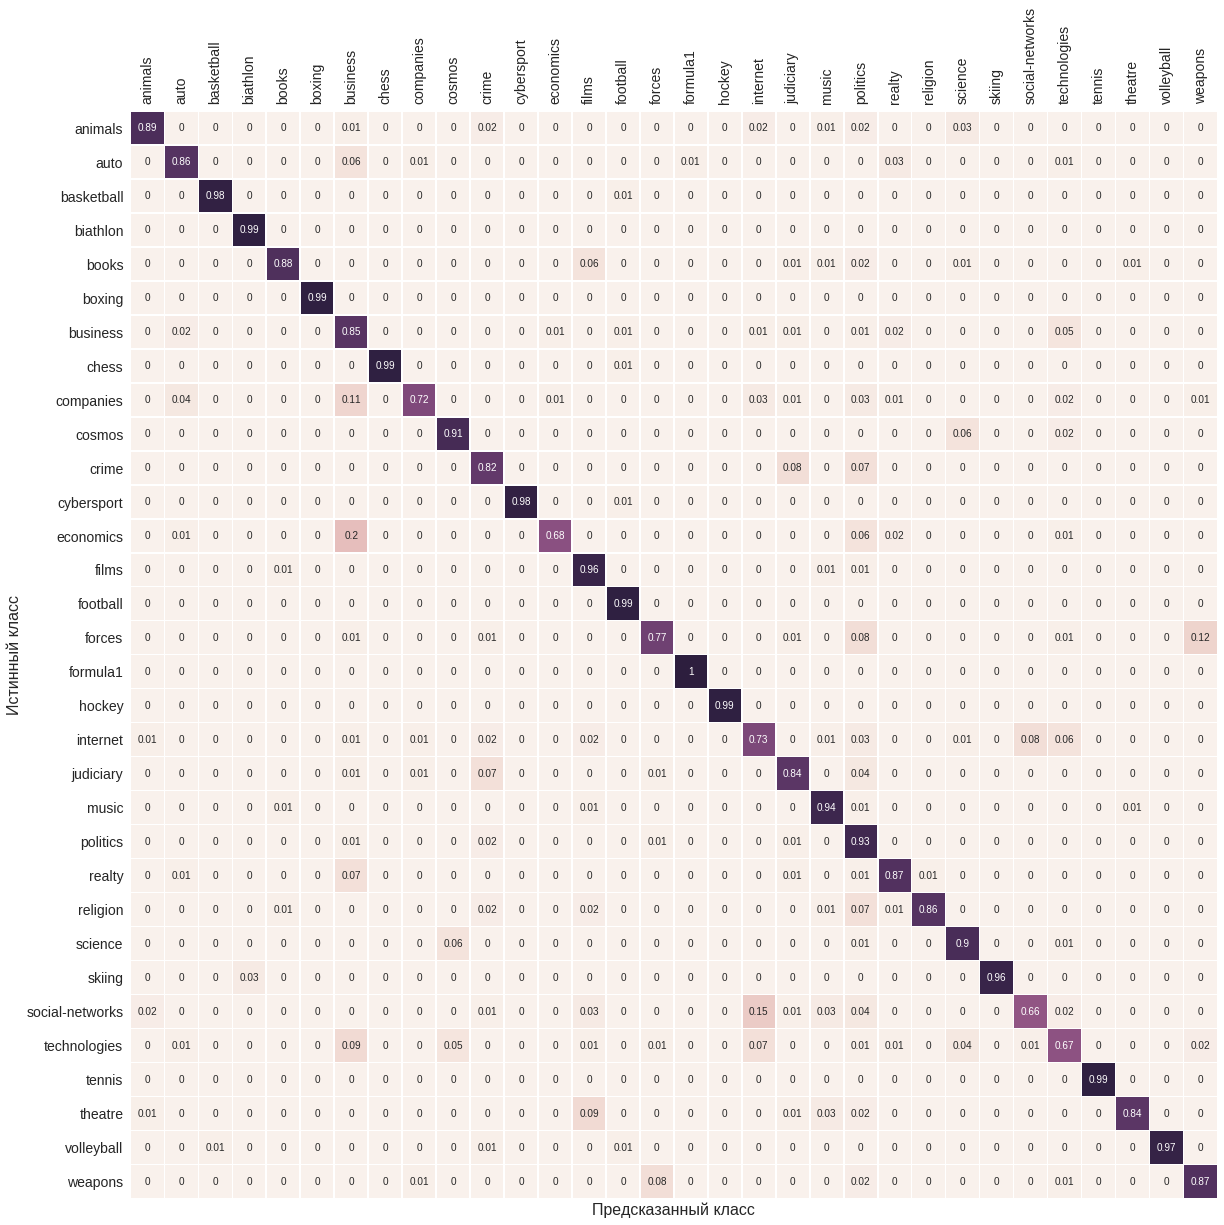

In [100]:
svm_cm_normalized = plot_confusion_matrix(y_test, svm_prediciton, le.classes_, 'svm_confusion_matrix')

In [50]:
def plot_accuracy_per_class(conf_matrix, classes, filename=None):
    class_scores = {}
    for i in range(conf_matrix.shape[0]):
        class_scores[classes[i]] = conf_matrix[i,i]

    topics = []
    scores = []
    for topic, score in sorted(class_scores.items(), key=lambda x: x[1]):
        topics.append(topic)
        scores.append(score)

    font_size=15
    fig, ax = plt.subplots(1, 1, figsize=(12, 12))
    ax.barh(range(len(topics)), scores, color='#6C7A89')
    ax.set_yticks(range(len(topics)));
    ax.set_xticks(np.arange(0, 1.01, 0.1));
    ax.set_yticklabels(topics);
    ax.tick_params(labelsize=font_size)
    ax.xaxis.grid()
    ax.set_xlabel('Accuracy')
    if filename:
        fig.savefig('../docs/images/{}.pdf'.format(filename), bbox_inches='tight')

In [ ]:
plot_accuracy_per_class(svm_cm_normalized, le.classes_, 'svm_accuracy_per_class')

### Посмотрим на ошибки классификации

In [ ]:
# for i, (true, pred) in enumerate(zip(y_test, clf_prediciton)):
#     if true == le.transform(['technologies'])[0] and pred == le.transform(['realty'])[0]:
#         print(X_test[i][1])

### Выведем слова с максимальным весом внутри каждого класса

In [ ]:
def print_top_K(vectorizer, clf, class_labels, k=10):
    """Prints features with the highest coefficient values, per class"""
    feature_names = vectorizer.get_feature_names()
    top_words = {}
    for i, class_label in enumerate(class_labels):
        top_K = np.argsort(clf.coef_[i])[-k:]
        top_words[class_label] = [feature_names[j] for j in top_K]
    return pd.DataFrame(top_words)

In [ ]:
df = print_top_K(tfidf_vectorizer, clf, le.classes_, k=8)

In [ ]:
column_format='c|'+'c'*8

In [ ]:
with open('top_10_svm_words.tex', 'w') as f: 
    print(df.transpose().to_latex(escape=False, header=False, column_format=column_format), file=f)

# Обучим Word2vec

In [ ]:
from gensim.models import Word2Vec
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [ ]:
corpus = pd.read_csv('../data/DATA_MANY_TOPICS.csv')[['text', 'topic']]

In [ ]:
corpus.text = corpus.text.apply(TEXT_PIPELINE)

In [25]:
min_count = 3
vec_size = 300
window = 5

In [ ]:
%%time
w2v = Word2Vec([text.split() for text in corpus.text],
                min_count=min_count, size=vec_size, window=window, hs=1, sg=1, workers=8, iter=10)

In [ ]:
word_vectors = w2v.wv
del w2v

In [23]:
import pickle
# with open('../data/w2v.pickle', 'wb') as f:
#     pickle.dump(word_vectors, f, pickle.HIGHEST_PROTOCOL)
with open('../data/w2v.pickle', 'rb') as f:
    word_vectors = pickle.load(f)

### Усредним вектора слов в каждой из новостей с весами tf-idf

In [26]:
word2tfidf = dict(zip(tfidf_vectorizer.get_feature_names(), tfidf_vectorizer.idf_))
vectorized_news = np.zeros((trainX.shape[0], vec_size), dtype="float32")
for i in tqdm(range(trainX.shape[0])):
    words = [word for word in trainX.text.iloc[i].split()
             if word in word_vectors and word in word2tfidf]
    word_vecs = [word_vectors[word] for word in words]
    word_idfs = [word2tfidf[word]  for word in words]
    vectorized_news[i,:] = np.average(word_vecs, axis=0, weights=word_idfs)

100%|██████████| 133529/133529 [00:56<00:00, 2350.61it/s]


In [27]:
trainX_w2v = pd.DataFrame(vectorized_news)

In [28]:
trainX_w2v.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
0,0.122689,0.022116,-0.055775,0.102848,-0.059617,-0.209706,0.071718,0.029721,-0.013314,-0.001266,0.067837,-0.008261,-0.054157,-0.045808,-0.103458,0.080133,0.073717,-0.125134,0.086407,-0.073933,0.158153,0.020989,-0.009119,-0.076712,-0.047917,-0.034019,0.078457,-0.009983,-0.012556,-0.008714,0.118016,0.045488,0.056933,0.065484,0.132058,-0.079166,-0.218975,-0.198329,-0.098605,-0.108403,0.023593,0.046939,-0.030261,-0.018180,0.014389,-0.033944,0.085475,-0.093280,0.053087,0.217663,-0.053958,0.063938,0.144915,0.152364,-0.102352,0.009113,-0.000849,0.021968,-0.032137,0.102670,-0.033337,-0.147354,-0.004213,0.162184,0.107334,0.061264,0.024760,0.128071,-0.028242,-0.165984,-0.128697,-0.005391,-0.077225,0.056289,-0.055309,-0.119862,0.070745,0.124794,-0.000066,0.071108,0.026062,0.163846,-0.050215,0.108951,-0.031971,0.115741,-0.088055,0.086442,-0.150871,0.130117,-0.159550,0.061656,0.081962,0.056993,0.024507,-0.012912,0.066536,-0.103571,-0.136026,-0.171697,-0.031582,0.051363,0.036841,-0.038754,-0.031184,-0.068913,0.073523,-0.079091,0.002953,-0.084151,-0.038270,-0.025728,-0.014409,0.030166,0.049994,0.024997,0.008246,-0.149352,-0.081479,0.094951,0.022137,0.030098,0.064552,0.087744,0.006291,-0.052014,-0.036706,0.050980,-0.038613,0.001861,-0.064162,0.011208,-0.036459,0.018126,-0.098160,-0.090936,-0.051550,0.075881,0.073329,0.026288,0.112026,-0.010810,0.167439,0.064363,-0.110784,0.026092,0.131332,-0.039865,-0.187197,-0.111974,0.001052,0.025095,-0.085744,0.089078,0.063144,0.076791,0.066206,-0.152718,0.023297,0.016109,0.067599,0.082856,-0.027691,0.073205,0.087119,0.010992,0.067820,0.002337,0.070471,0.029190,0.002748,-0.044316,0.070132,0.238911,0.004024,-0.033171,-0.062886,0.110889,-0.043873,0.107346,-0.135767,-0.033024,0.149924,-0.221892,-0.060429,-0.027645,-0.071618,-0.019616,-0.090920,-0.061619,0.082570,0.059860,0.030097,-0.028099,0.112822,0.129588,-0.068734,0.092147,-0.061825,-0.114435,-0.019826,-0.134128,-0.103826,0.055703,-0.032666,0.003003,0.102656,0.042906,0.020780,0.014857,0.066612,0.035893,-0.092749,0.216551,-0.090150,0.012473,-0.034957,0.006764,-0.013429,-0.002136,-0.039886,0.058865,0.021341,0.068681,-0.098911,0.025077,0.009102,0.132863,-0.150130,0.066055,0.068914,0.026436,0.113660,-0.183317,-0.141147,0.070568,0.141939,-0.139534,-0.108865,-0.001305,0.036582,0.140602,-0.173676,-0.004264,0.016145,0.060858,0.030558,-0.159698,0.053381,0.014990,0.036011,0.031957,0.028706,0.033119,0.021043,-0.239722,-0.100063,-0.072304,0.043649,-0.056375,-0.078967,-0.106359,-0.145545,0.094009,0.013467,0.013988,-0.161217,0.082760,-0.105197,-0.100408,-0.002643,0.031146,-0.018975,-0.058355,-0.050926,-0.020063,-0.085252,-0.047775,0.041175,-0.069963,-0.108940,0.005717,-0.070165,-0.039006,-0.140284,-0.124071,-0.004563,-0.166020,0.031284,0.063163,0.126451,0.019169,0.016217,-0.011270,-0.033348,0.070927,-0.025293,-0.007515,0.015203,-0.002064
1,0.076850,0.096206,-0.045763,0.083596,0.014016,-0.130288,0.07

In [ ]:
trainX_w2v = pd.read_csv('trainX_w2v.csv')
# trainX_w2v.to_csv('./trainX_w2v.csv')

In [29]:
trainX_w2v.shape, trainY.shape

((133529, 300), (133529,))

# Получим распределение топиков с помощью BigARTM

In [ ]:
import warnings
warnings.simplefilter('ignore')
import artm

### Удалим слова, встречающиеся только один раз

In [ ]:
corpus.text = corpus.text.apply(lambda x: ' '.join([w for w in str(x).split() if vocabulary[w] > 1]))

### Создадим файл в формате vowpal wabbit

In [ ]:
vw_file_name = '../data/news_for_bigartm.vw'
with open(vw_file_name, 'w') as file:
    for i, doc in enumerate(corpus.text):
        print('doc{} {}'.format(i+1, doc), file=file)

### Создадим батчи для обучения и загрузим их в словарь bigARTM

In [ ]:
batch_vectorizer = artm.BatchVectorizer(data_path=vw_file_name, data_format='vowpal_wabbit',
                                        target_folder='../data/bigartm_batches')

In [ ]:
dictionary = artm.Dictionary()
dictionary.gather(data_path='../data/bigartm_batches')

### Инициализируем ARTM модель.
Добавим к ней регуляризаторы декорреляции и разреженности для матриц $\Theta$ и $\Phi$. 

In [ ]:
%%time
model = artm.ARTM(num_topics=150, dictionary=dictionary, cache_theta=True, show_progress_bars=True)

model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.2))
model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=3e5))
model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SmoothSparseThetaRegularizer', tau=-0.001))

model.scores.add(artm.PerplexityScore(name='perplexity_score', dictionary=dictionary))
model.scores.add(artm.TopTokensScore(name='top_tokens_score', dictionary=dictionary))
model.num_tokens = 10 # макс. число токенов для отображения

model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=50)


In [ ]:
saved_top_tokens = model.score_tracker['top_tokens_score'].last_tokens
for topic, top_tokens in saved_top_tokens.items():
    print(topic, *top_tokens)

In [ ]:
def create_batch(documents, vocab):
    ''' Creates bath from list of documents 
        :param: documents - list of documents represented as string,
            eg. ['Hello world!', 'How are you? - I am fine, thanks!']
        
        :param: vocab - dict of term frequencies
        
        :return: bigARTM batch
    '''
    
    import uuid
    from collections import defaultdict
    
    batch = artm.messages.Batch()
    batch.id = str(uuid.uuid4())
    dictionary = {}

    # first step: fill the general batch vocabulary
    for i, token in enumerate(vocab):
        batch.token.append(token)
        dictionary[token] = i

    # second step: fill the items
    for doc in documents:
        item = batch.item.add()    
        local_dict = defaultdict(int)
        for token in doc.split():
            local_dict[token] += 1
        for k, v in local_dict.items():
            if k in dictionary:
                item.token_id.append(dictionary[k])
                item.token_weight.append(v)
    return batch

In [ ]:
batch = create_batch(trainX.text.values, vocabulary)
bigartm_feats = model.master.transform(batches=[batch])[1]
top_cols = sorted(saved_top_tokens.keys(), key=lambda x: int(x.split('_')[1]))

In [36]:
# pd.DataFrame(bigartm_feats, columns=top_cols).to_csv('../data/data_bigartm_feats.csv')
# trainX_bigartm = pd.DataFrame(bigartm_feats, columns=top_cols)
trainX_bigartm = pd.read_csv('../data/data_bigartm_feats.csv')

In [37]:
del trainX_bigartm['Unnamed: 0']

In [38]:
trainX_bigartm.shape, trainX_w2v.shape

((133529, 150), (133529, 300))

# Обучим градиентный бустинг (LightGBM)

In [31]:
import lightgbm as lgb
import warnings
warnings.simplefilter('ignore')

In [39]:
# pd.concat([trainX_w2v, trainX_bigartm], axis=1)
X_train, X_test, y_train, y_test = train_test_split(pd.concat([trainX_w2v, trainX_bigartm], axis=1).values, trainY.values, test_size=0.3,
                                                    stratify=trainY.values, random_state=42)
lgb_train = lgb.Dataset(X_train, y_train)
lgb_valid = lgb.Dataset(X_test, y_test)

In [40]:
X_train.shape

(93470, 450)

In [45]:
lgb_param = {
    'colsample_bytree': 0.9,
    'is_unbalance': False,
    'learning_rate': 0.1,
    'max_bin': 255,
    'max_depth': 7,
    'min_child_samples': 10,
    'min_child_weight': 5,
    'min_split_gain': 0,
    'nthread': 4,
    'num_leaves': 255,
    'objective': 'multiclass',
    'metric': 'multi_error',
    'is_training_metric': True,
    'num_class': len(le.classes_),
    'reg_alpha': 0,
    'reg_lambda': 0,
    'silent': True,
    'subsample': 0.8, #0.8
}

In [46]:
%%time
clf = lgb.train(lgb_param, lgb_train, num_boost_round=10000, valid_sets=[lgb_valid],
            early_stopping_rounds=100, verbose_eval=25)

Train until valid scores didn't improve in 100 rounds.
[25]	valid_0's multi_error: 0.190619
[50]	valid_0's multi_error: 0.17297
[75]	valid_0's multi_error: 0.163484
[100]	valid_0's multi_error: 0.158242
[125]	valid_0's multi_error: 0.154522
[150]	valid_0's multi_error: 0.151302
[175]	valid_0's multi_error: 0.14888
[200]	valid_0's multi_error: 0.146933
[225]	valid_0's multi_error: 0.145336
[250]	valid_0's multi_error: 0.144761
[275]	valid_0's multi_error: 0.143638
[300]	valid_0's multi_error: 0.142065
[325]	valid_0's multi_error: 0.141466
[350]	valid_0's multi_error: 0.140643
[375]	valid_0's multi_error: 0.139969
[400]	valid_0's multi_error: 0.139769
[425]	valid_0's multi_error: 0.13867
[450]	valid_0's multi_error: 0.138421
[475]	valid_0's multi_error: 0.137922
[500]	valid_0's multi_error: 0.137597
[525]	valid_0's multi_error: 0.136948
[550]	valid_0's multi_error: 0.136673
[575]	valid_0's multi_error: 0.136174
[600]	valid_0's multi_error: 0.135875
[625]	valid_0's multi_error: 0.1355
[65

In [ ]:
# np.save('lgb_prediciton_w2v_only', lgb_prediciton)
# lgb_prediciton = np.load('lgb_prediciton_w2v_only.npy')

In [47]:
lgb_prediciton = clf.predict(X_test).argmax(axis=1)
print('F1 score:', f1_score(y_test, lgb_prediciton, average='macro'))
print('Accuracy:', accuracy_score(y_test, lgb_prediciton))

# w2v only:
# F1 score: 0.848625247727
# Accuracy: 0.842781896702 26 min

# bigARTM only:
# F1 score: 0.825758239533
# Accuracy: 0.837190144537

# bigARTM + w2v:
# F1 score: 0.871120225443
# Accuracy: 0.868743603185
# 51min 7s

F1 score: 0.871120225443
Accuracy: 0.868743603185


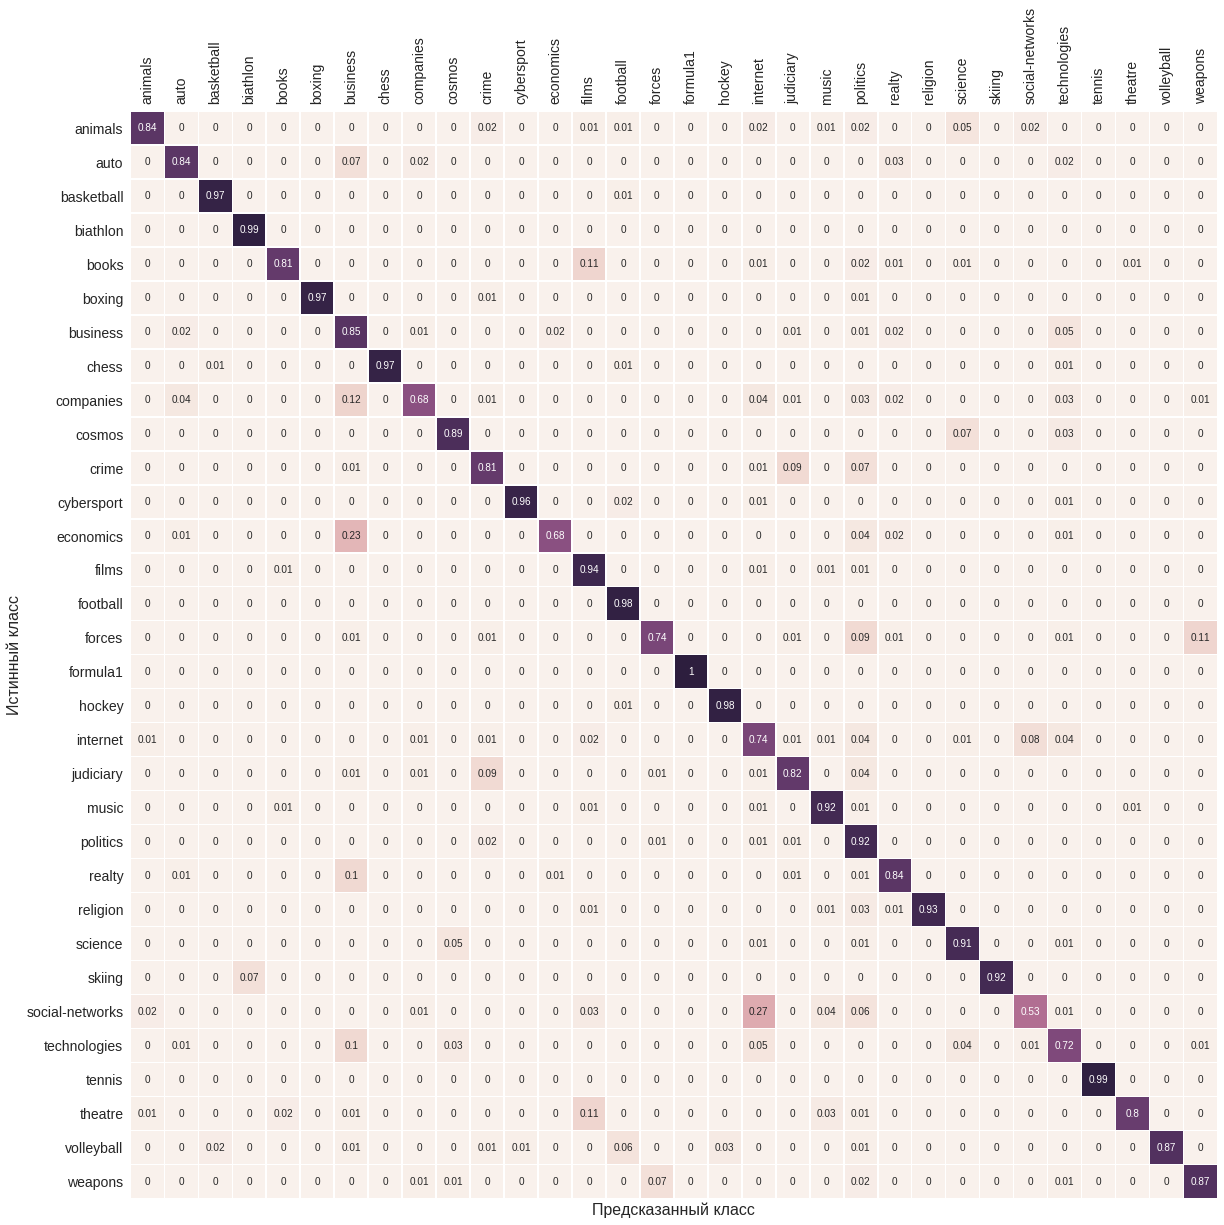

In [51]:
lgb_cm_normalized = plot_confusion_matrix(y_test, lgb_prediciton, le.classes_, 'lgb_bigartm_w2v_confusion_matrix')

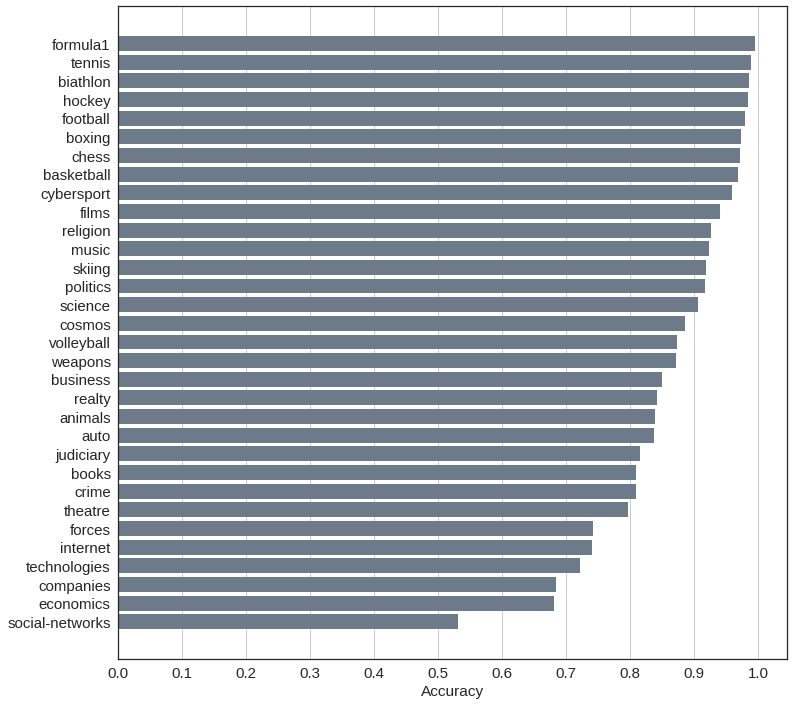

In [52]:
plot_accuracy_per_class(lgb_cm_normalized, le.classes_, 'lgb_bigartm_w2v_accuracy_per_class')

In [126]:
def show_values(pc, fmt="%.2f", **kw):
    '''
    Heatmap with text in each cell with matplotlib's pyplot
    Source: http://stackoverflow.com/a/25074150/395857 
    By HYRY
    '''
    pc.update_scalarmappable()
    ax = pc.get_axes()
    for p, color, value in zip(pc.get_paths(), pc.get_facecolors(), pc.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.all(color[:3] > 0.5):
            color = (0.0, 0.0, 0.0)
        else:
            color = (1.0, 1.0, 1.0)
        ax.text(x, y, fmt % value, ha="center", va="center", color=color, **kw);


def cm2inch(*tupl):
    '''
    Specify figure size in centimeter in matplotlib
    Source: http://stackoverflow.com/a/22787457/395857
    By gns-ank
    '''
    inch = 2.54
    if type(tupl[0]) == tuple:
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)


def heatmap(AUC, title, xlabel, ylabel, xticklabels, yticklabels,
            figure_width=40, figure_height=20, correct_orientation=False, cmap='RdBu'):
    '''
    Inspired by:
    - http://stackoverflow.com/a/16124677/395857 
    - http://stackoverflow.com/a/25074150/395857
    '''

    # Plot it out
    fig, ax = plt.subplots();    
    #c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap='RdBu', vmin=0.0, vmax=1.0)
    c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap=cmap, vmin=0.5, vmax=1.0);

    # put the major ticks at the middle of each cell
    ax.set_yticks(np.arange(AUC.shape[0]) + 0.5, minor=False);
    ax.set_xticks(np.arange(AUC.shape[1]) + 0.5, minor=False);

    # set tick labels
    #ax.set_xticklabels(np.arange(1,AUC.shape[1]+1), minor=False)
    ax.set_xticklabels(xticklabels, minor=False);
    ax.set_yticklabels(yticklabels, minor=False);

    # set title and x/y labels
    plt.title(title)
    plt.xlabel(xlabel);
    plt.ylabel(ylabel);     

    # Remove last blank column
    plt.xlim( (0, AUC.shape[1]) )

    # Turn off all the ticks
    ax = plt.gca();    
    for t in ax.xaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False
    for t in ax.yaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False

    # Add color bar
#     plt.colorbar(c);

    # Add text in each cell 
    show_values(c);

    # Proper orientation (origin at the top left instead of bottom left)
    if correct_orientation:
        ax.invert_yaxis();
        ax.xaxis.tick_top();       

    # resize 
    fig = plt.gcf();
    #fig.set_size_inches(cm2inch(40, 20))
    #fig.set_size_inches(cm2inch(40*4, 20*4))
    fig.set_size_inches(cm2inch(figure_width, figure_height));



def plot_classification_report(classification_report, title='', cmap='RdBu'):
    '''
    Plot scikit-learn classification report.
    Extension based on http://stackoverflow.com/a/31689645/395857 
    '''
    lines = classification_report.split('\n')

    classes = []
    plotMat = []
    support = []
    class_names = []
    for line in lines[2 : (len(lines) - 2)]:
        t = line.strip().split()
        if len(t) < 2: continue
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        support.append(int(t[-1]))
        class_names.append(t[0])
#         print(v)
        plotMat.append(v)

#     print('plotMat: {0}'.format(plotMat))
#     print('support: {0}'.format(support))
    classes = classes[::-1]
    plotMat = plotMat[::-1]
    support = support[::-1]
    class_names = class_names[::-1]
    
    xlabel = ''
    ylabel = ''
    xticklabels = ['Precision', 'Recall', 'F1-score']
    yticklabels = ['{0} ({1})'.format(class_names[idx], sup) for idx, sup  in enumerate(support)]
    figure_width = 25
    figure_height = len(class_names) + 7
    correct_orientation = False
    heatmap(np.array(plotMat), title, xlabel, ylabel, xticklabels, yticklabels, figure_width, figure_height, correct_orientation, cmap=cmap);

In [128]:
plot_classification_report(classification_report(y_test, lgb_prediciton, target_names=le.classes_))
plt.savefig('../docs/images/lgb_w2v_bigartm_classif_report.pdf', bbox_inches='tight')
plt.close()

In [127]:
plot_classification_report(classification_report(y_test, svm_prediciton, target_names=le.classes_))
plt.savefig('../docs/images/svm_classif_report.pdf', bbox_inches='tight')
plt.close()